# Dask Graph Import Example
The purpose of this notebook is to explore the usage of dask dataframes as an scalable data import path. Examples of this type of workflow are seen in [cuGraph](https://github.com/rapidsai/cugraph) as `from_cudf_edgelist`and [networkx](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html) as `from_pandas_edgelist`.

I am proposing to provide similar semantics with the same underlying idea as [modin](https://github.com/modin-project/modin). The purpose is to take advantage of underlying scalable nature of data processing frameworks like Ray and Dask while providing an very flexible schema mapping workflow through dataframes.

## Table of Contents
- Part 1: Loading data as data frames
- Part 2: Dataframe to graph example (Dask -> Pandas -> Networkx)
- Part 3: Katana Graph Schema Mapping Pseudocode
- Part 4: Full LDBC schema mapping example
- Part 5: Distributed and remote variations with Dask and Ray
- Appendix: cuDF and cuGraph

## Part 1: Loading data as data frames
Read in all CSVs of LDBC as data frames

In [1]:
import os
import dask.dataframe as dd

In [20]:
def csv_to_df(path):
    df = dd.read_csv(os.path.join(path, '*.csv'),
                       delimiter='|',
                       assume_missing=True,
                       dtype={
                           'id': int},
                       converters={
                           'creationDate': pd.to_datetime,
                           'language': lambda x: x.split(';'),
                           'email': lambda x: x.split(';')})
    type_name = os.path.basename(path)
    # df['type'] = type_name
    # df['typed_id'] = df.apply(lambda row: type_name + ':' + str(row['id']), axis=1, meta=('typed_id', 'str'))
    return df

def dfs_from_directory(path):
    paths = [path]
    dfs = {}
    while paths:
        path = paths.pop()
        if not os.path.isdir(path):
            continue
        if any(file.endswith(".csv") for file in os.listdir(path)):
            # print("reading CSVs from " + path)
            dfs[os.path.basename(path)] = csv_to_df(path)
            continue
        paths.extend(map(lambda x : os.path.join(path,x), os.listdir(path)))
    return dfs

In [21]:
merged_fk_dfs = dfs_from_directory('katana-repositories/social-network-sf0.003-bi-composite-merged-fk/')
projected_fk_dfs = dfs_from_directory('katana-repositories/social-network-sf0.003-bi-composite-projected-fk/')

print("merged foreign key dataframes...")
print(", ".join(merged_fk_dfs))   
print("Projected foreign key dataframes...")
print(", ".join(projected_fk_dfs))

merged foreign key dataframes...
TagClass, Tag, Place, Organisation, Person_likes_Comment, Person_studyAt_University, Forum_hasTag_Tag, Person_knows_Person, Person_likes_Post, Forum, Person_workAt_Company, Person_hasInterest_Tag, Comment, Person, Comment_hasTag_Tag, Post_hasTag_Tag, Forum_hasMember_Person, Post, batch_id=2012-12-23, batch_id=2012-12-24, batch_id=2012-12-25, batch_id=2012-12-22, batch_id=2012-11-29, batch_id=2012-12-31, batch_id=2012-12-16, batch_id=2012-12-18, batch_id=2012-12-20, batch_id=2012-12-21, batch_id=2012-12-19, batch_id=2012-12-17, batch_id=2012-12-09, batch_id=2012-12-30, batch_id=2012-12-29, batch_id=2012-12-27, batch_id=2012-12-26, batch_id=2012-12-10, batch_id=2012-12-02, batch_id=2012-12-05, batch_id=2012-11-30, batch_id=2012-12-28, batch_id=2012-12-12, batch_id=2012-12-15, batch_id=2012-12-14, batch_id=2012-12-13, batch_id=2012-12-07, batch_id=2012-12-06, batch_id=2012-12-01, batch_id=2012-12-08, batch_id=2012-12-11, batch_id=2012-12-03, batch_id=2012-

In [23]:
merged_fk_dfs['TagClass'].head()

,id,name,url,SubclassOfTagClassId
0,349,OfficeHolder,http://dbpedia.org/ontology/OfficeHolder,211.0
1,211,Person,http://dbpedia.org/ontology/Person,239.0
2,239,Agent,http://dbpedia.org/ontology/Agent,0.0
3,0,Thing,http://www.w3.org/2002/07/owl#Thing,NaN
4,98,Monarch,http://dbpedia.org/ontology/Monarch,211.0


## Part 2: Dataframe to graph example (Dask -> Pandas -> Networkx)

In [5]:
import networkx as nx
import pandas as pd

### Example: Merged Foreign Keys
Only looking at TagClass dataframe, use only one dataframe for both edge and nodes

In [6]:
#tag_class = dfs['TagClass'].dropna(subset=['SubclassOfTagClassId']).astype({'SubclassOfTagClassId': 'int'}).compute()
#tag_class['typed_SubclassOfTagClassId'] = tag_class.apply(lambda row: 'TagClass:' + str(row['SubclassOfTagClassId']), axis=1)
df = merged_fk_dfs['TagClass']
df['type'] = 'isSubclassOf'
G = nx.from_pandas_edgelist(df.compute(), 'id', 'SubclassOfTagClassId', 'type')
node_attr = merged_fk_dfs['TagClass'][['id','name','url']].set_index('id').compute().to_dict('index')
nx.set_node_attributes(G, node_attr)

/Users/andrew/miniconda3/envs/experimental/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


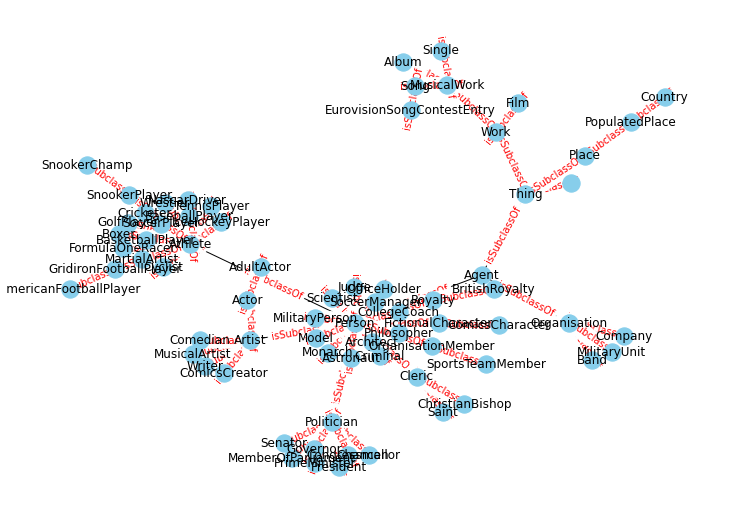

In [7]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [10.0, 7.0]
plt.rcParams["figure.autolayout"] = True
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G,'name')
nx.draw(G, labels=node_labels, with_labels=True, node_color='skyblue', pos = pos)
edge_labels = nx.get_edge_attributes(G,'type') # key is edge, pls check for your case
formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')
plt.show()

### Example: Projected Foreign Keys

In [8]:
df = projected_fk_dfs['TagClass_isSubclassOf_TagClass'].astype({
    'TagClass1Id': 'int32',
    'TagClass2Id': 'int32'})
df['type'] = 'isSubclassOf'
G = nx.from_pandas_edgelist(df.compute(),
                            source='TagClass1Id',
                            target='TagClass2Id',
                            edge_attr='type')
node_attr = projected_fk_dfs['TagClass'][['id','name','url']].set_index('id').compute().to_dict('index')
nx.set_node_attributes(G, node_attr)

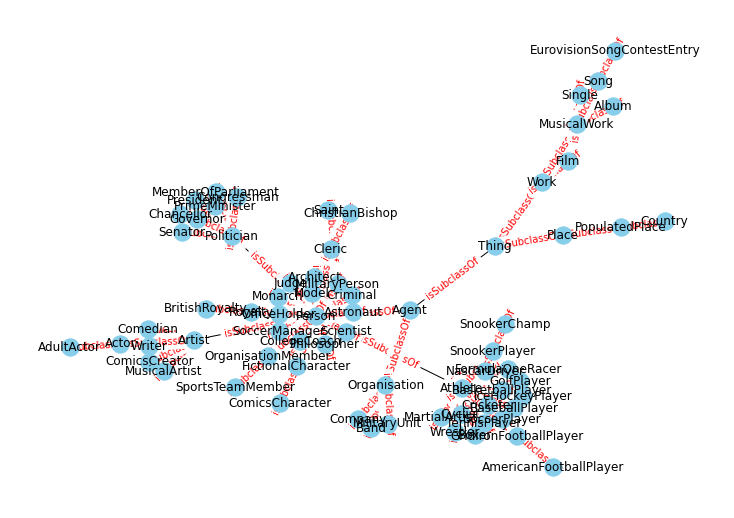

In [9]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [10.0, 7.0]
plt.rcParams["figure.autolayout"] = True
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G,'name')
nx.draw(G, labels=node_labels, with_labels=True, node_color='skyblue', pos = pos)
edge_labels = nx.get_edge_attributes(G,'type') # key is edge, pls check for your case
formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')
plt.show()

## Part 3: The Katana Graph Schema Mapping Pseudocode
This section describes the different APIs that could provide a very flexible schema mapping path from dataframes to graphs.
- Supporting merged foreign keys:
    - **new graph:** `katana.from_dask_edgelist(dataframe, source, target, node_properties=None, node_type=None, edge_properties=None, edge_type=None)`
        - `dataframe: dask.dataframe`
        - `source: string` - column name for source id
        - `target: string` - column name for target id
        - `node_properties: string or list` - column names to use as source node properties
        - `source_type: string` - static value
        - `target_type: string` - static value
        - `edge_properties: string or list` - column names to use as edge properties
        - `edge_type: string` - static value
    - **existing graph:** `katana.insert_dask_edgelist(graph, dataframe, source, target, node_properties=None, node_type=None, edge_properties=None, edge_type=None)`
- Supporting projected foreign keys (nodes & edge lists):
    - Edge List:
        - **new graph:** `katana.from_dask_edgelist(...)`
        - **existing graph:** `katana.insert_dask_edgelist(...)`
    - Node List:
        - **new graph:** `katana.from_dask_nodelist(dataframe, id, node_properties=None, node_type=None)`
            - `dataframe: dask.dataframe`
            - `id: string` - column name for id
            - `node_properties: string or list` - column names to use as node_properties, use all if None
            - `node_type: string` - **TODO(andrew):** decide whether this is a column or a static value
        - **existing graph:** `katana.insert_dask_nodelist(graph, dataframe, id, node_properties=None, node_type=None)`
    
**Note: Filter on ingest can be accomplished by subsetting dataframes**

In [ ]:
# merged foreign key example (need to support rows where target is empty)
G = katana.from_dask_edgelist(merged_fk_dfs['TagClass'],
                               'id', 'SubclassOfTagClassId',
                               ['type','name','url'])

# projected foreign key example (edges then nodes)
G = katana.from_dask_edgelist(projected_fk_dfs['TagClass_isSubclassOf_TagClass'],
                              'TagClass1Id', 'TagClass2Id')
katana.from_dask_nodelist(G, projected_fk_dfs['TagClass'], id='id', node_type='TagClass')

# projected foreign key example 2 (nodes then edges)
G = katana.from_dask_nodelist(projected_fk_dfs['TagClass'], id='id', node_type='TagClass')
katana.insert_dask_edgelist(G, projected_fk_dfs['TagClass_isSubclassOf_TagClass'],
                            source='TagClass1Id', target='TagClass2Id')

## Part 3: The Katana Graph Dataframe Pseudocode
This section describes dataframes for downstream computation

In [ ]:
from katana.remote.analytics import pagerank
pagerank(
    graph,
    result_property_name='page_rank'
)

result = graph.query("""
MATCH (acct1)
RETURN acct1
LIMIT 10
""")

df = result.to_dask_dataframe()

## Part 4: Full LDBC schema mapping example
- **new graph:** `katana.from_dask_dataframes(edgelists=[{dataframe, id=None, source=None, target=None, node_properties=None, node_type=None, edge_properties=None, edge_type=None}])`
    - `dataframe: dask.dataframe`
    - `id: string` - column name for id
        - if `source` and `target` are set, it is an edge id
        - if `source=None`and `target!=None`, treat as `source`
        - else, it is a node id and treating the dataframe as a nodelist
    - `source: string` - column name for source id
    - `target: string` - column name for target id
    - `node_properties: string or list` - column names to use as source node properties
    - `node_type: string or list` - static value (for nodelist)
    - `source_type: string` - static value (for edgelist or merged foreign key format)
    - `target_type: string` - static value (for edgelist or merged foreign key format)
    - `edge_properties: string or list` - column names to use as edge properties
    - `edge_type: string or list` - static value
    - `converters` - pandas converters to apply to dataframe

In [46]:
dfs_to_import = ['TagClass', 'Tag', 'Place', 'Organisation', 'Person_likes_Comment',
                 'Person_studyAt_University', 'Forum_hasTag_Tag', 'Person_knows_Person',
                 'Person_likes_Post', 'Forum', 'Person_workAt_Company', 'Person_hasInterest_Tag',
                 'Comment', 'Person', 'Comment_hasTag_Tag', 'Post_hasTag_Tag',
                 'Forum_hasMember_Person', 'Post']

dfs = {key: merged_fk_dfs[key] for key in dfs_to_import}
print(", ".join(dfs))
dfs['Organisation'].head()
#dfs['Organisation'][dfs['Organisation'].type != 'Company'].head()

TagClass, Tag, Place, Organisation, Person_likes_Comment, Person_studyAt_University, Forum_hasTag_Tag, Person_knows_Person, Person_likes_Post, Forum, Person_workAt_Company, Person_hasInterest_Tag, Comment, Person, Comment_hasTag_Tag, Post_hasTag_Tag, Forum_hasMember_Person, Post


,id,type,name,url,LocationPlaceId
0,0,Company,Kam_Air,http://dbpedia.org/resource/Kam_Air,59.0
1,1,Company,Balkh_Airlines,http://dbpedia.org/resource/Balkh_Airlines,59.0
2,2,Company,Khyber_Afghan_Airlines,http://dbpedia.org/resource/Khyber_Afghan_Airl...,59.0
3,3,Company,MarcoPolo_Airways,http://dbpedia.org/resource/MarcoPolo_Airways,59.0
4,4,Company,Pamir_Airways,http://dbpedia.org/resource/Pamir_Airways,59.0


In [ ]:
G = katana.from_dask_edgelists([
    # TagClass
    {dataframe=merged_fk_dfs['TagClass'],
     source='id', target='SubclassOfTagClassId',
     node_properties=['name','url'],
     source_type='TagClass',
     target_type='TagClass',
     edge_type='SubclassOf'},
    # Tag
    {dataframe=merged_fk_dfs['Tag'],
     source='id', target='TypeTagClassId',
     node_properties=['name','url'],
     source_type='Tag',
     target_type='TagClass',
     edge_type='hasType'},
    # Person
    {dataframe=merged_fk_dfs['Person'],
     id='id',
     node_type='Person'},
    # Person_knows_Person
    # TODO(andrew): does order matter?
    {dataframe=merged_fk_dfs['Person_knows_Person'],
     id='Person1Id', target='Person2Id',
     edge_properties=['creationDate'],
     source_type='Person',
     target_type='Person',
     edge_type='knows'},
    # Person_hasInterest_Tag
    {dataframe=merged_fk_dfs['Person_hasInterest_Tag'],
     source='PersonId', target='TagId',
     edge_properties=['creationDate'],
     source_type='Person',
     target_type='Tag',
     edge_type='hasInterest'},
    # Place
    {dataframe=merged_fk_dfs['Place'],
     id='id',
     target='PartOfPlaceId',
     node_type='type',
     node_properties=['name','url'],
     edge_type='partOf',
     converters={
         'type': lambda x: ['Place'].append(x)
     },
     # Organisation
     {dataframe=merged_fk_dfs['Organisation'],
     id='id',
     target='LocationPlaceId',
     node_type='type',
     node_properties=['name','url'],
     edge_type='isLocatedIn',
     converters={
         'type': lambda x: ['Organisation'].append(x)
     },
     ...
    )                             

## Part 5: Remote variations with Dask and Ray
(See [modin](https://github.com/modin-project/modin) for similar expectations)

### Dask Example

In [ ]:
import katana.remote.dask as dd
import katana.remote
from katana.remote import Graph

client = katana.remote.Client(num_workers = 3)

# read data into a dask DataFrame using read_csv (uses client)
df = dd.read_csv(os.path.join('graph_data.csv'), dtype={'source': int, 'target': int})

# Create a graph using source and destination vertex pairs
# This creates a graph with the same number of partitions as the number of dask workers
G = katana.remote.from_dask_edgelist(df, source='source', target='target')

# Alternatively, create a graph first then insert edgelist
G2 = client.create_graph(num_partitions = 3)
katana.remote.insert_dask_edgelist(G2, df, source='source', target='target')

# Compute PageRank and write existing score to each vertex
katana.remote.analytics.pagerank(G, result_property_name='page_rank')

# View results as a dataframe
result = graph.query("""MATCH n RETURN n""")

df = result.to_dask_dataframe()

### Ray Example

In [ ]:
import katana.remote.ray as rd


## Appendix: cuDF and cuGraph
**TODO(andrew):** Try LDBC on cuGraph

In [ ]:
import cugraph

# read data into a cuDF DataFrame using read_csv
gdf = cudf.read_csv("graph_data.csv", names=["src", "dst"], dtype=["int32", "int32"])

# We now have data as edge pairs
# create a Graph using the source (src) and destination (dst) vertex pairs
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='src', destination='dst')

# Let's now get the PageRank score of each vertex by calling cugraph.pagerank
df_page = cugraph.pagerank(G)

# Let's look at the PageRank Score (only do this on small graphs)
for i in range(len(df_page)):
    print("vertex " + str(df_page['vertex'].iloc[i]) +
        " PageRank is " + str(df_page['pagerank'].iloc[i]))